# Absenteeism at work 

Problem definition: predict the time of absence of an employee knowing some information of the reasons or the type of person. 

## Unsupervised Learning 

**Goal:** Create cluster for columns that relate of employee personal caracteristics. 

**Methods:** I will use first Kmeans and may use Hierarchical clustering method to compare the output of 2 different methods. 

**Unsupervised Learning tasks:** 
- [x] Define columns that can be gathered as a cluster 
- [x] Check distribution of data and relation between each other (apply scaling if necessary)
- [x] Build model using Kmeans 
- [x] Plot the clusters to check the relevance of them
- [x] Use Silouhette coefficient and Davies Bouldin evaluation metrics to check the performance of the model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

pd.set_option('max_columns',25)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('../data/absenteeism_clean.csv')
print(df.shape)
df.head()

(697, 21)


,id,reason_for_absence,month_of_absence,day_of_the_week,seasons,transportation_expense,distance_from_residence_to_work,service_time,age,work_load_average_day,hit_target,education,children,social_drinker,social_smoker,pet,weight,height,body_mass_index,absenteeism_bins,total_disciplinary_failures
0,11,26,7,3,1,289,36,13,33,239.554,97,1,2,1,0,1,90,172,30,"(2.0, 4.0]",2
1,11,23,7,5,1,289,36,13,33,239.554,97,1,2,1,0,1,90,172,30,"(-0.001, 2.0]",2
2,11,18,8,2,1,289,36,13,33,205.917,92,1,2,1,0,1,90,172,30,"(4.0, 8.0]",2
3,11,23,8,3,1,289,36,13,33,205.917,92,1,2,1,0,1,90,172,30,"(-0.001, 2.0]",2
4,11,18,8,4,1,289,36,13,33,205.917,92,1,2,1,0,1,90,172,30,"(4.0, 8.0]",2


In [42]:
df.id.nunique()

33

In [3]:
cluster_cols = ['education','children','social_drinker','social_smoker','pet','weight',
                'height','body_mass_index','age','distance_from_residence_to_work','transportation_expense']

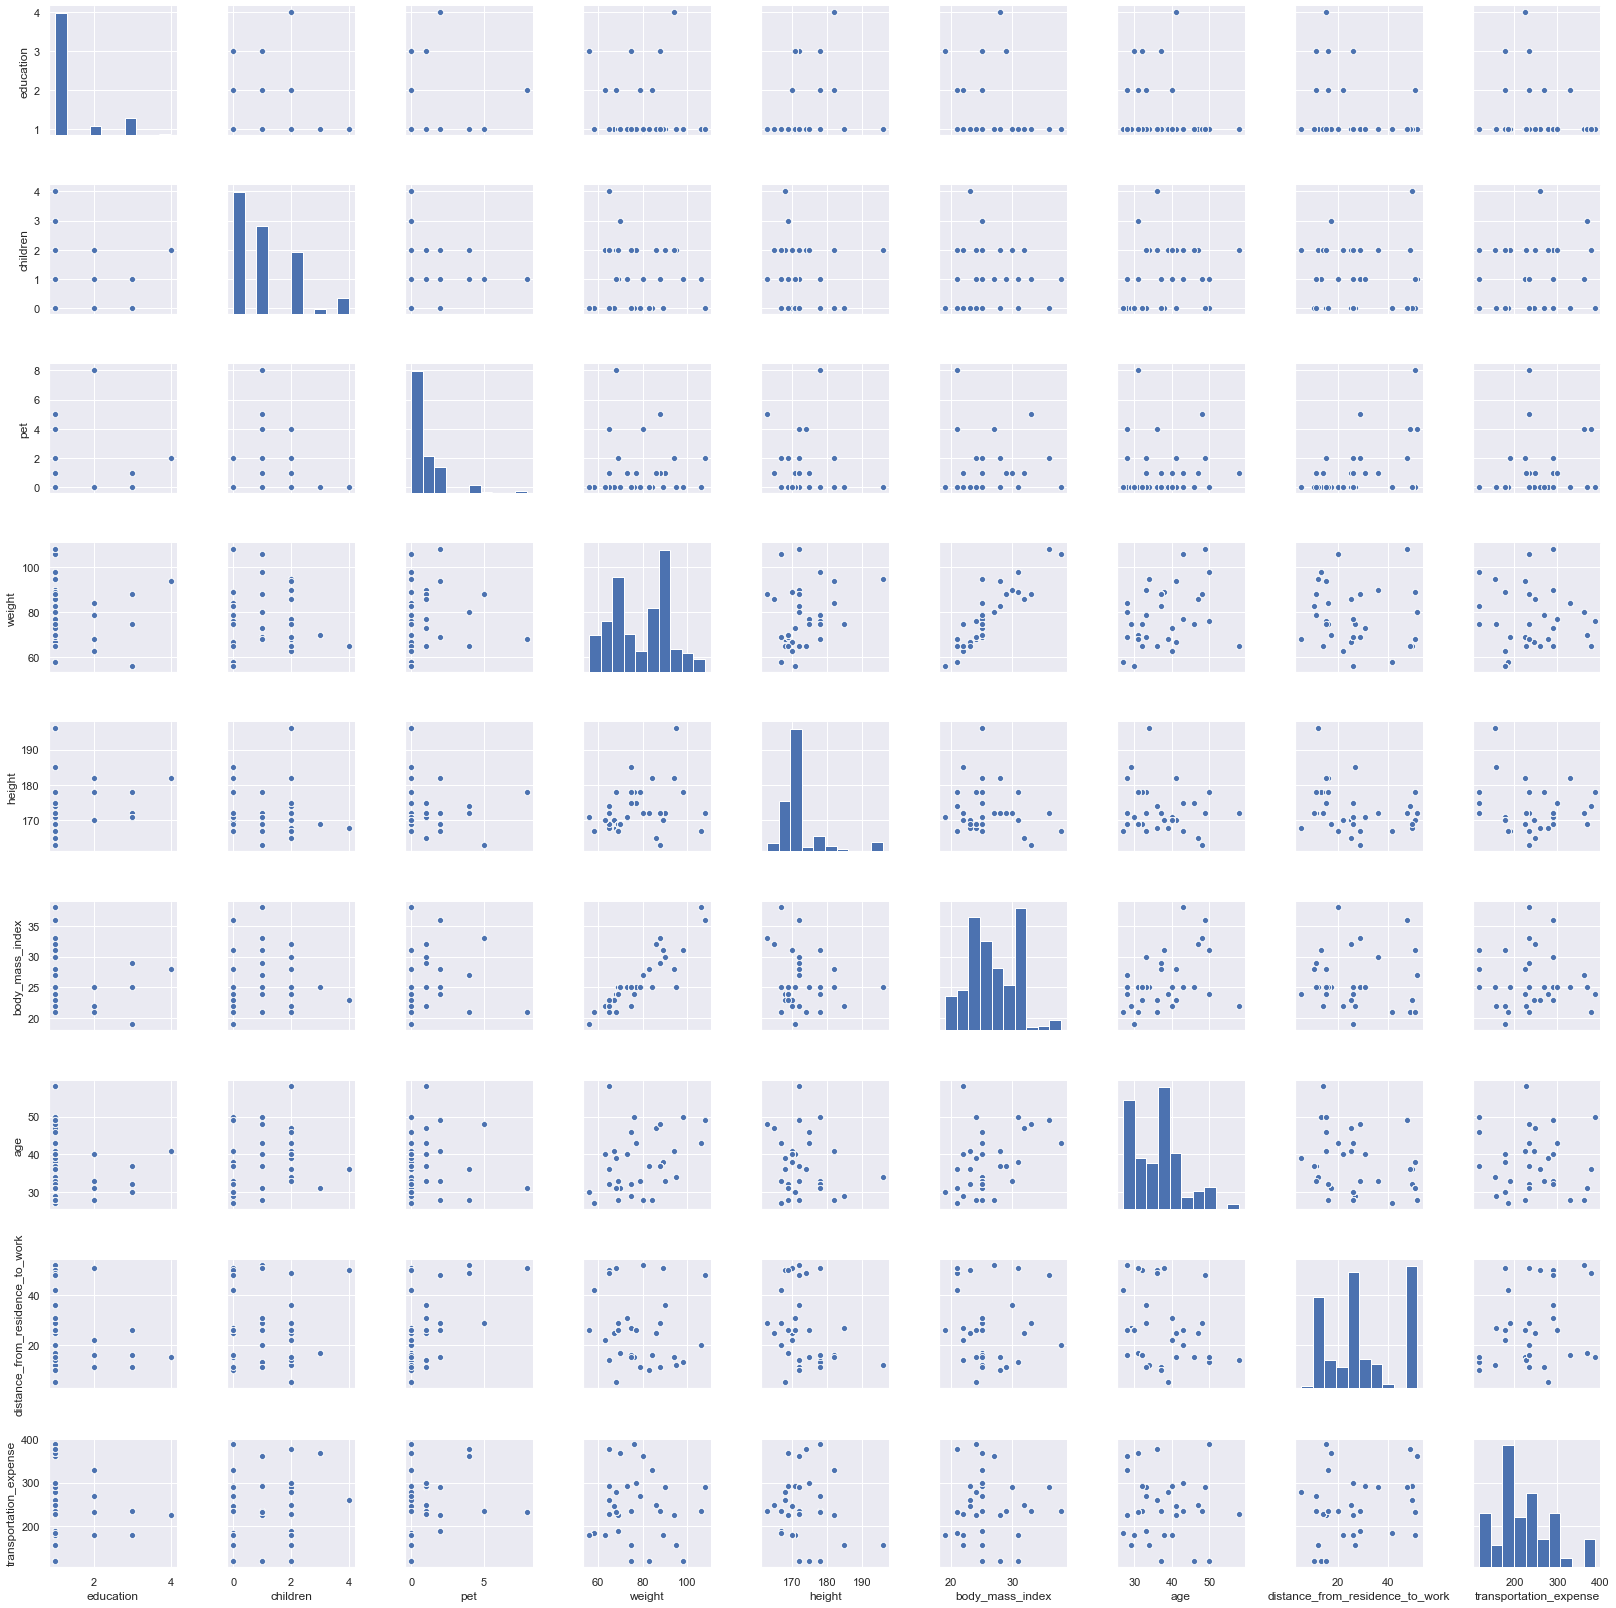

In [6]:
sns.pairplot(df[cluster_cols].drop(columns=['social_drinker','social_smoker']));

In [24]:
df[cluster_cols]

,education,children,social_drinker,social_smoker,pet,weight,height,body_mass_index,age,distance_from_residence_to_work,transportation_expense
0,1,2,1,0,1,90,172,30,33,36,289
1,1,2,1,0,1,90,172,30,33,36,289
2,1,2,1,0,1,90,172,30,33,36,289
3,1,2,1,0,1,90,172,30,33,36,289
4,1,2,1,0,1,90,172,30,33,36,289
...,...,...,...,...,...,...,...,...,...,...,...
692,2,1,1,0,8,68,178,21,31,51,233
693,2,1,1,0,8,68,178,21,31,51,233
694,2,1,1,0,8,68,178,21,31,51,233
695,1,2,1,1,0,75,175,25,46,15,118


## KMeans model

In [7]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

In [106]:
df_cluster = df.copy()

In [109]:
model = KMeans(n_clusters=3)
labels = model.fit_predict(df[cluster_cols])

df_cluster['cluster_label'] = labels

# Number of unique id per cluster_label
df_cluster.groupby('id').cluster_label.min().value_counts()

1    13
2    10
0    10
Name: cluster_label, dtype: int64

In [108]:
pd.crosstab(df_cluster.id,df_cluster.cluster_label)

cluster_label,0,1,2
id,,,
1,0,22,0
2,0,4,0
3,112,0,0
5,0,14,0
6,8,0,0
7,0,4,0
9,0,8,0
10,0,0,24
11,0,0,38


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/no

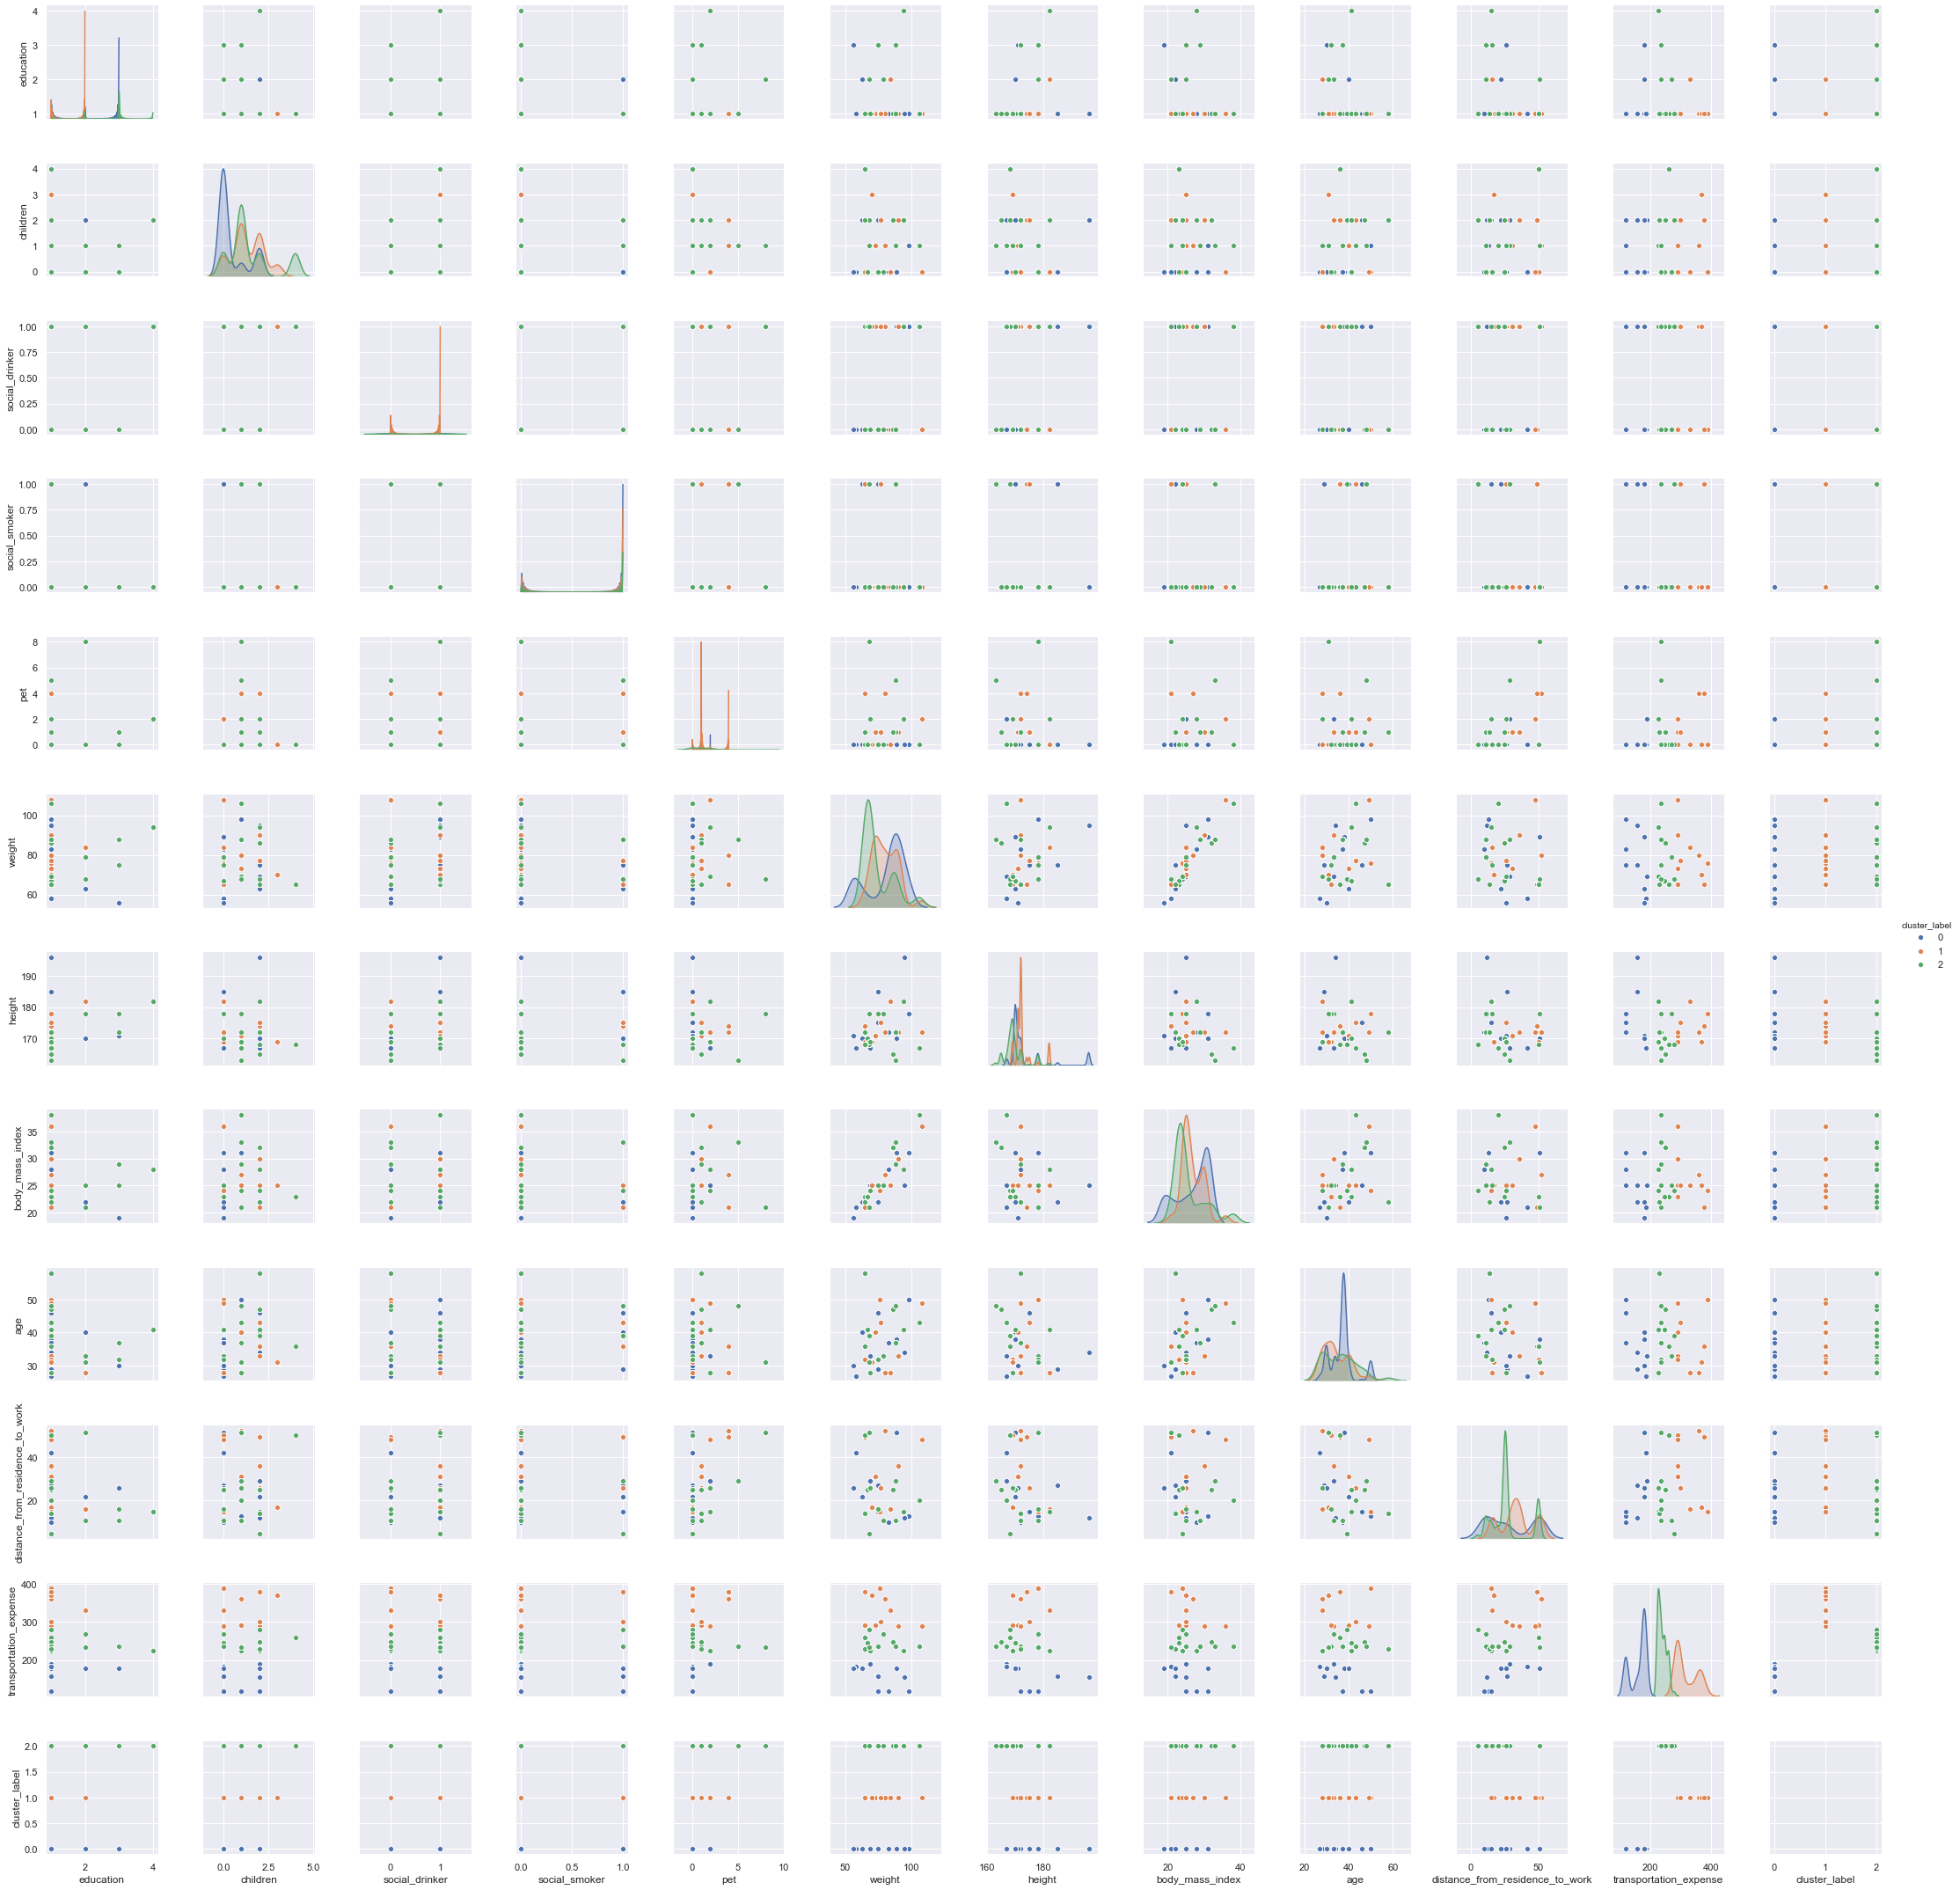

In [20]:
# Checking the relation of features and clusters

sns.pairplot(df_cluster[cluster_cols+['cluster_label']],hue='cluster_label');

In [110]:
# Checking accuracy of the cluster using evaluation metrics 

print('Scaled cluster')
print("DB score", davies_bouldin_score(df_cluster[cluster_cols], labels))
print('Avg Silouhette coef:', silhouette_score(df_cluster[cluster_cols], labels))

Scaled cluster
DB score 0.7405041013957973
Avg Silouhette coef: 0.5045038991037858


### Conclusion 
Here we can see the first approach is mostly based on transportation expenses because it is the column
with the higher scale data. 

Possible improvement:
- Apply a scaling method to weight equally the features

_________________________
## KMeans model on scaled data

- We will use the minmax scale method to reduce the weight of data with higher values
- Build the model and compare how the clusters are different

In [111]:
df_scaled = df.copy()

In [112]:
minmax_scale = ['weight','height','body_mass_index','age','distance_from_residence_to_work','transportation_expense']

for i in range(len(minmax_scale)):
    df_scaled[minmax_scale[i]] = (df_scaled[minmax_scale[i]] - df_scaled[minmax_scale[i]].min())/(df_scaled[minmax_scale[i]].max()- df_scaled[minmax_scale[i]].min())

df_scaled[cluster_cols].head()    
    

,education,children,social_drinker,social_smoker,pet,weight,height,body_mass_index,age,distance_from_residence_to_work,transportation_expense
0,1,2,1,0,1,0.653846,0.272727,0.578947,0.193548,0.659574,0.633333
1,1,2,1,0,1,0.653846,0.272727,0.578947,0.193548,0.659574,0.633333
2,1,2,1,0,1,0.653846,0.272727,0.578947,0.193548,0.659574,0.633333
3,1,2,1,0,1,0.653846,0.272727,0.578947,0.193548,0.659574,0.633333
4,1,2,1,0,1,0.653846,0.272727,0.578947,0.193548,0.659574,0.633333


In [113]:
# Building the model
model_scaled = KMeans(n_clusters=3)
labels_scaled = model_scaled.fit_predict(df_scaled[cluster_cols])

# Adding the labels to dataframe
df_cluster['cluster_label_scaled'] = labels_scaled

# Number of unique id per cluster_label
df_cluster.groupby('id').cluster_label_scaled.min().value_counts()

1    15
0    10
2     8
Name: cluster_label_scaled, dtype: int64

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/no

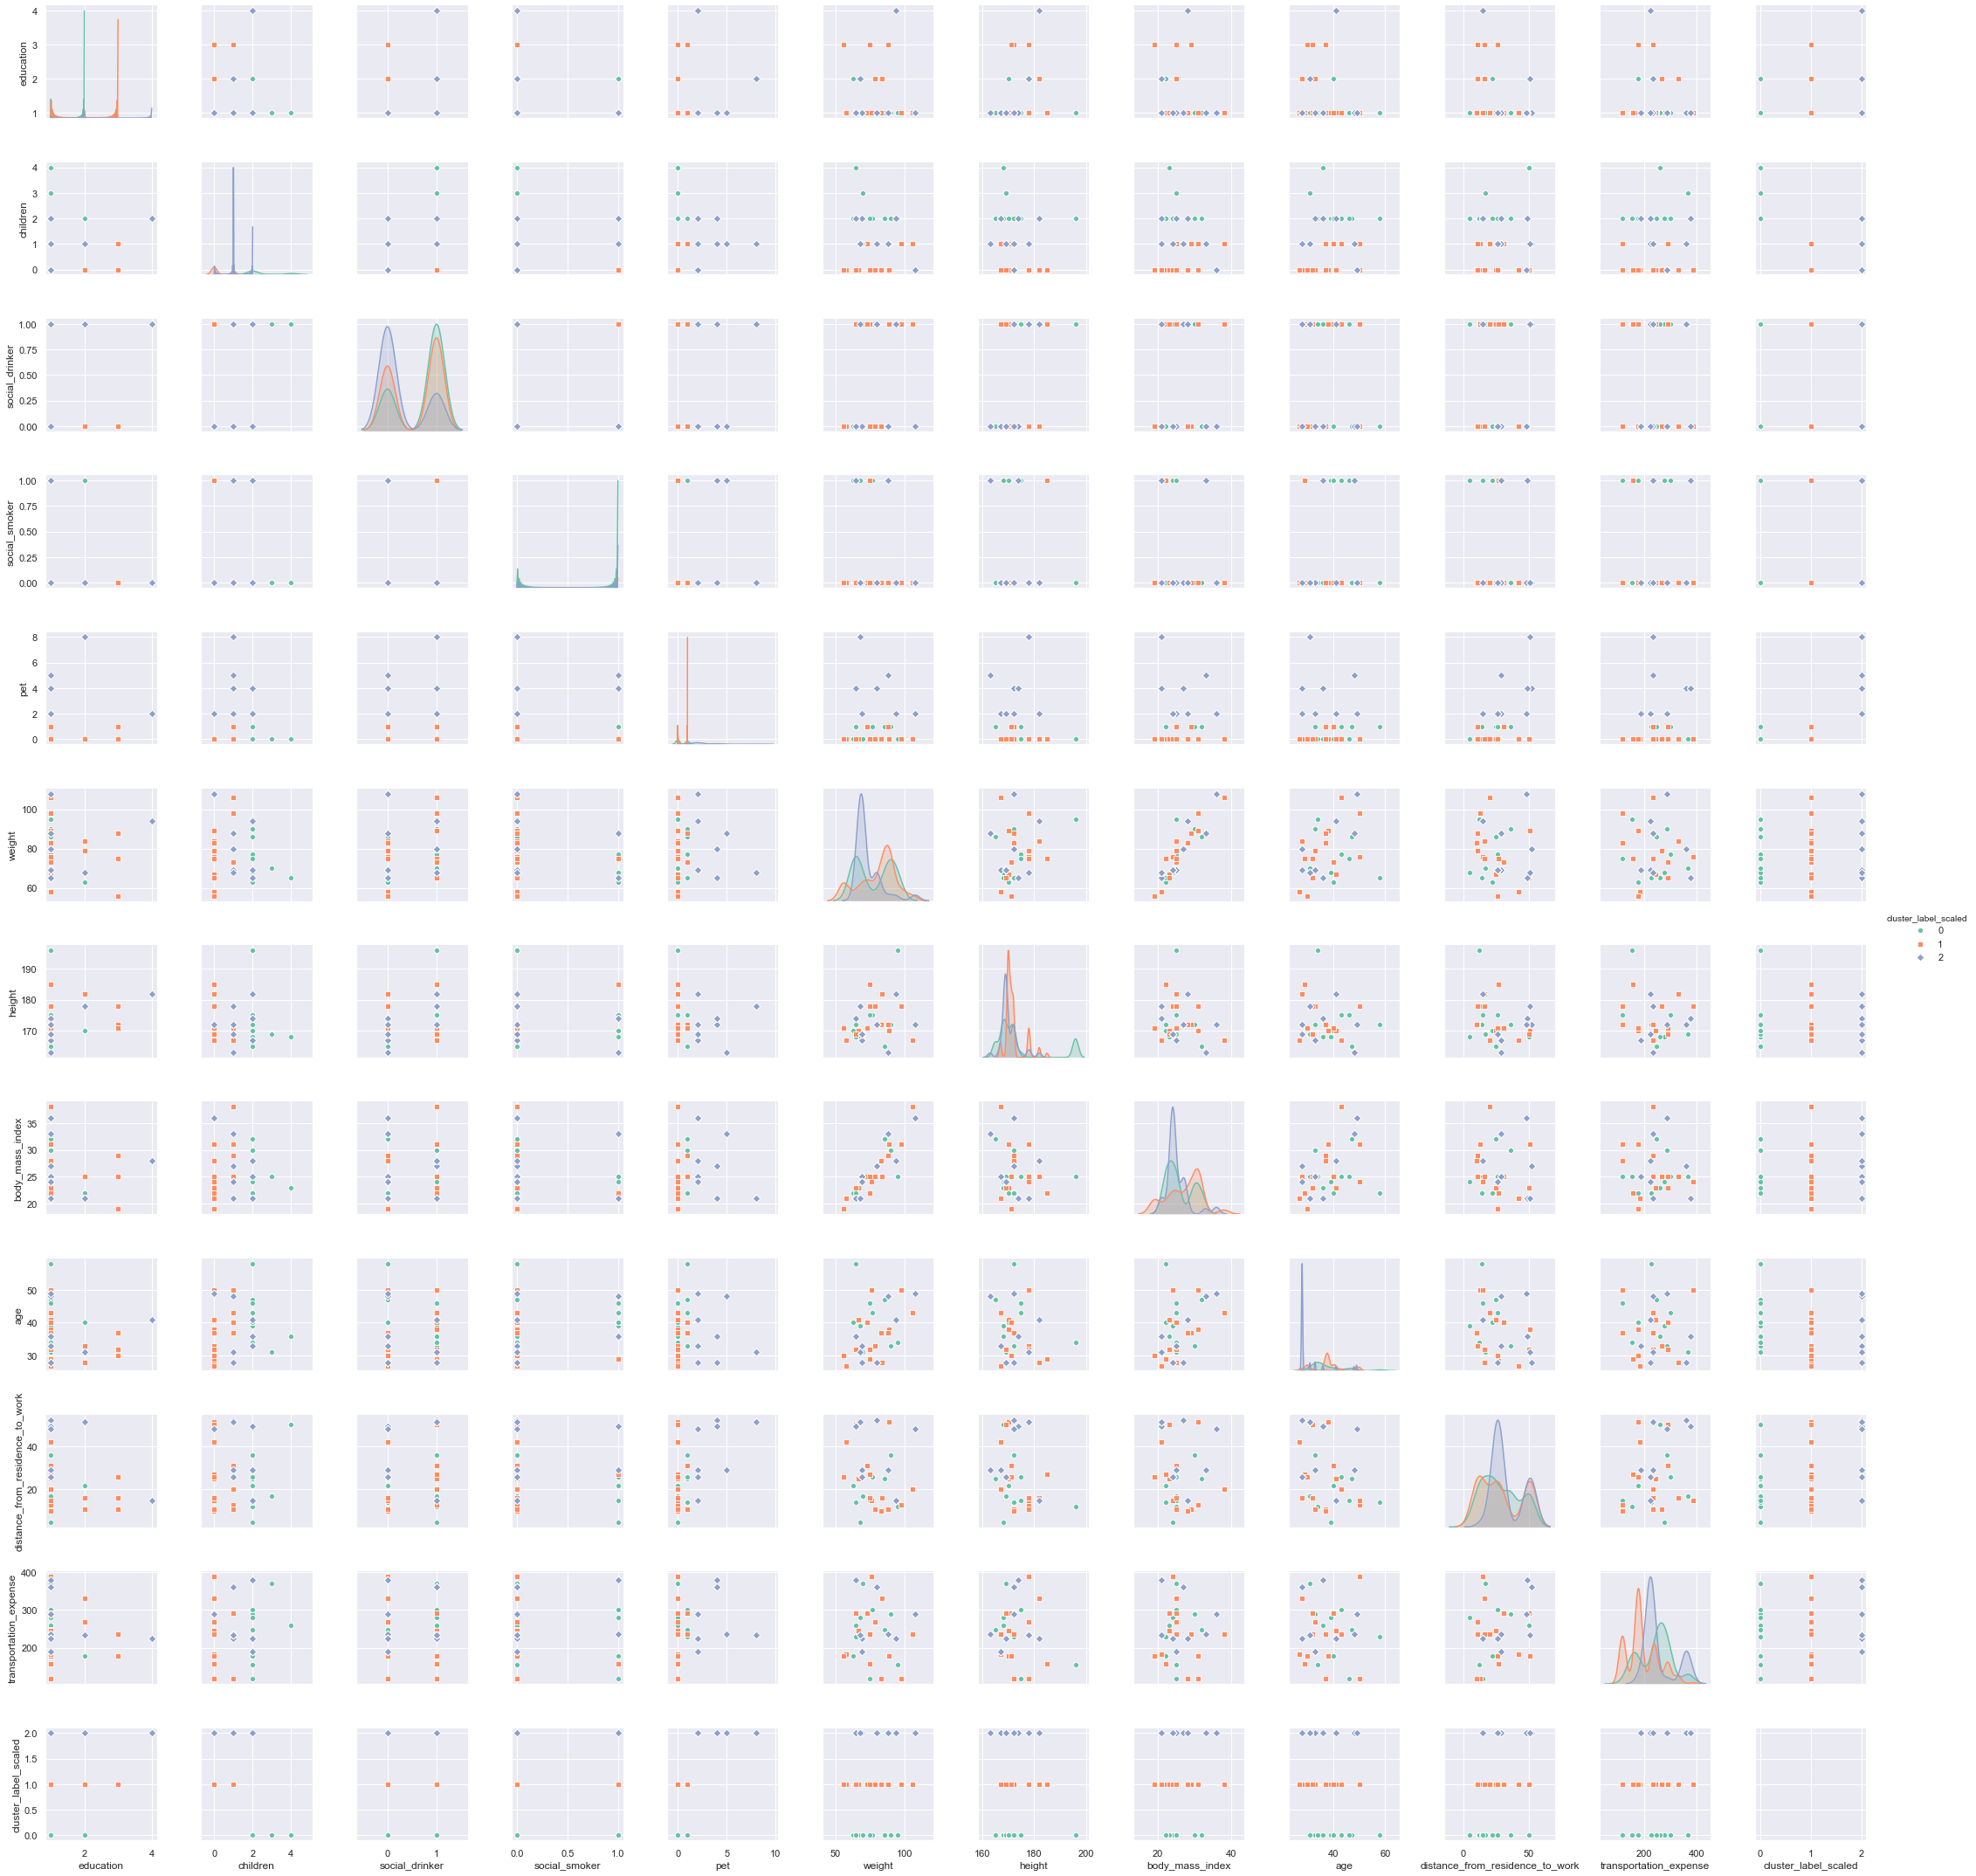

In [114]:
# Checking the relance of clusters through visualization - WARNING! Takes time to run. 

sns.pairplot(df_cluster[cluster_cols+['cluster_label_scaled']], kind="scatter", hue='cluster_label_scaled', markers=["o", "s", "D"], palette="Set2");



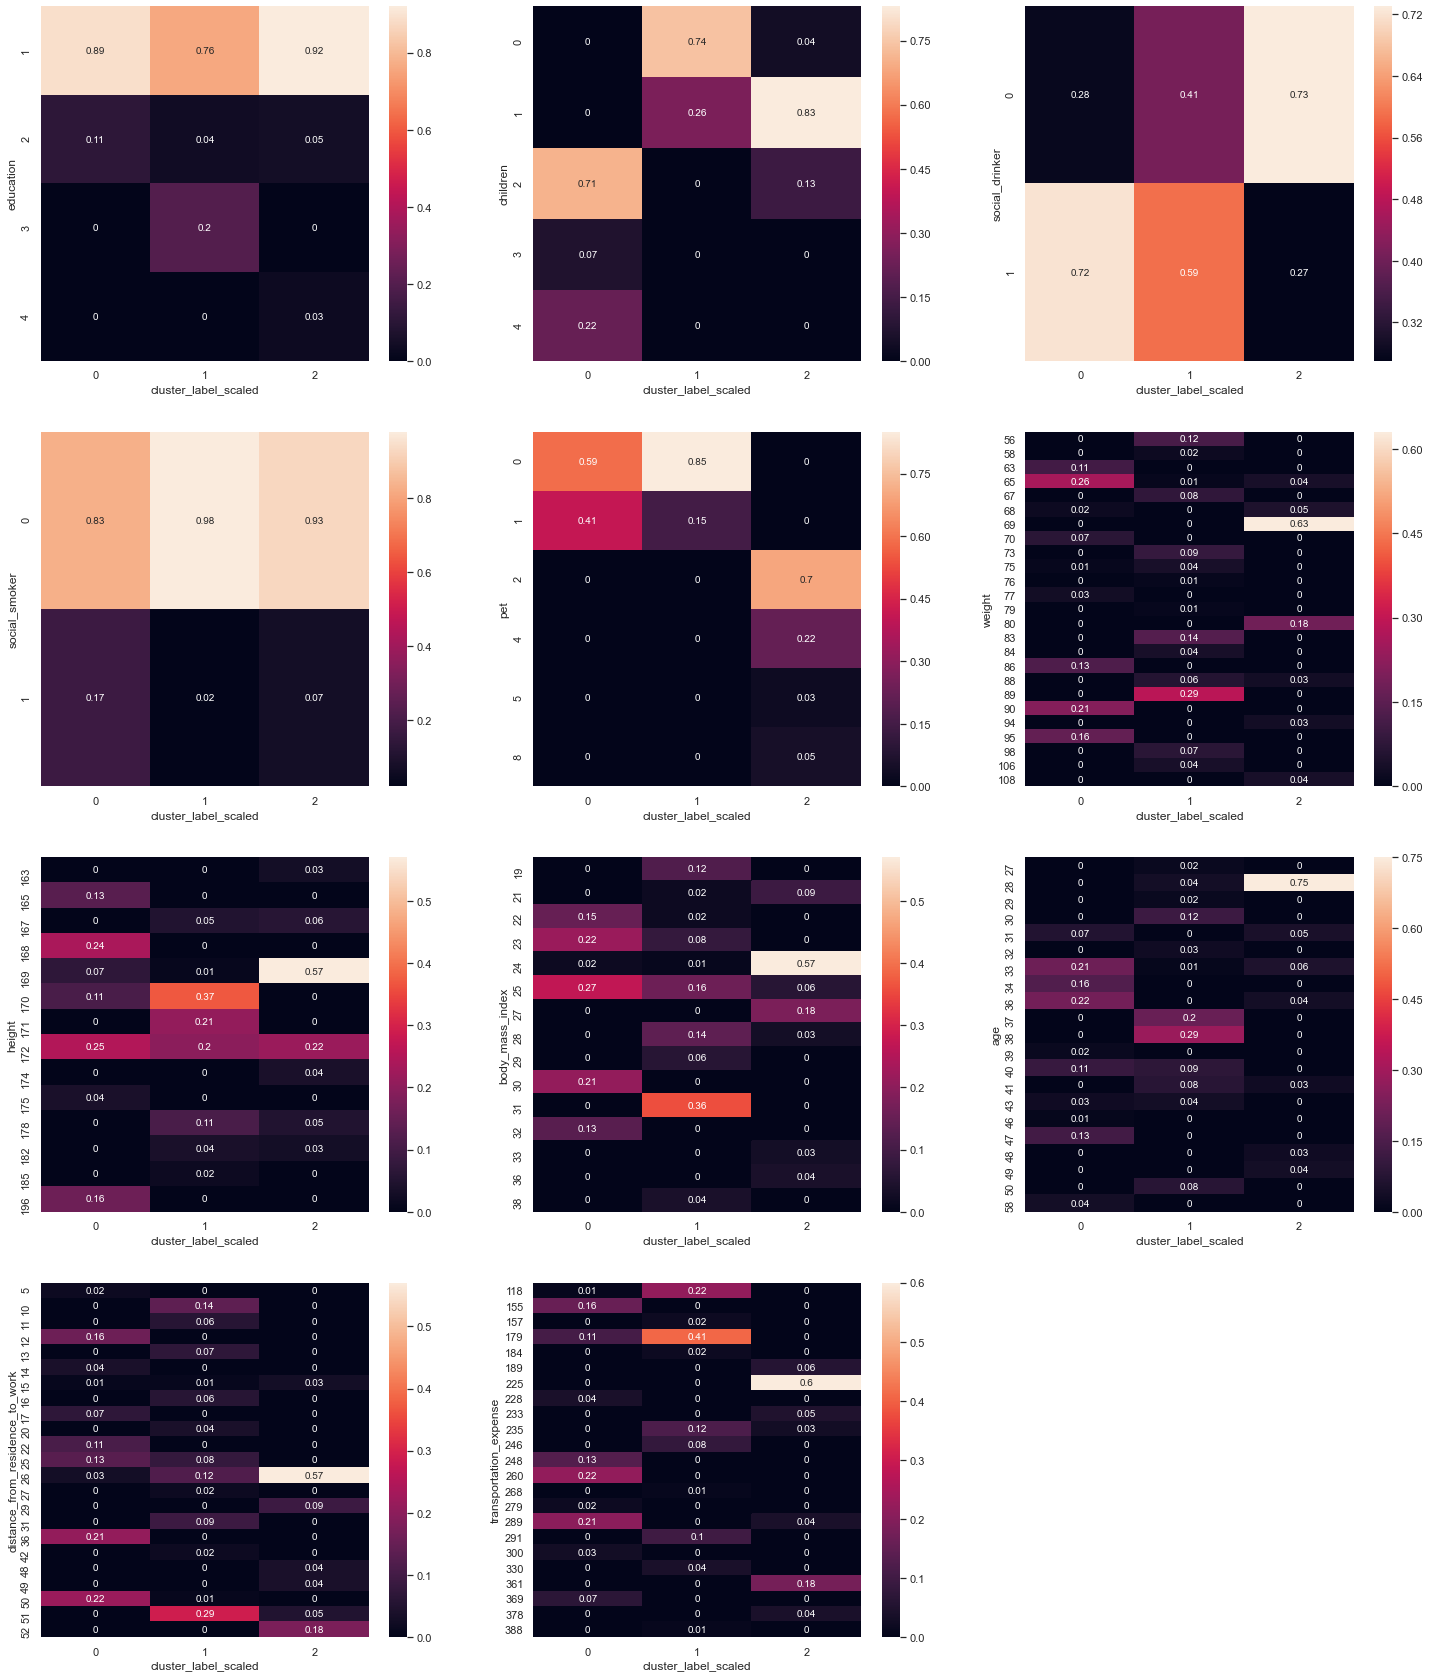

In [115]:
fig, axs=plt.subplots(4,3, figsize=(25,30))

for i in range(df_cluster[cluster_cols].shape[1]):
    tab = pd.crosstab(df_cluster[cluster_cols[i]],df_cluster['cluster_label_scaled'], normalize='columns').round(2)
    ax = axs[i//3,i%3]
    sns.heatmap(tab,annot=True,ax=ax)

fig.delaxes(axs[3,2])
plt.show()    
    

In [116]:
# Checking accuracy of the cluster using evaluation metrics 

print('Scaled cluster')
print("DB score", davies_bouldin_score(df_scaled[cluster_cols], labels_scaled))
print('Avg Silouhette coef:', silhouette_score(df_scaled[cluster_cols], labels_scaled))

Scaled cluster
DB score 1.035749998316972
Avg Silouhette coef: 0.42386791481603503


In [117]:
# Checking accuracy of the cluster using evaluation metrics 

print('Scaled cluster')
print("DB score", davies_bouldin_score(df_cluster[cluster_cols], labels_scaled))
print('Avg Silouhette coef:', silhouette_score(df_cluster[cluster_cols], labels_scaled))

Scaled cluster
DB score 5.324139907971243
Avg Silouhette coef: 0.09828817181347359


### Conclusions 

In regards of the evaluation metrics we can see that the clusters are overlapping, which is not that good.

But when checking visually the difference between the clusters we can see the clusters differenciate mostly with:
- number of children (cluster 0 has mostly no children; cluster 1 has 1 or 2 children; cluster 3 has 2 or more children)
- number of pet (cluster 0 has no pet; cluster 1 has mostly 2 or more pets; cluster 2 between 0 and 1)
- social drinker (cluster 0 is both drinkers and not; cluster 1 is mostly not social drinkers; cluster 2 is mostly social drinkers)

**Possible improvements:**
- Iterating on the number of clusters (2 or 4)
- Test using Hierarchical  Clustering

In [122]:
# Saving the new dataframe with the cluster

df_final = df_cluster.drop(columns=cluster_cols+['cluster_label']).copy().rename(columns={'cluster_label_scaled':'cluster'})
print(df_final.shape)

df_final.to_csv('../data/absenteeism_clusterized.csv', index=False)

df_final.head()

(697, 11)


,id,reason_for_absence,month_of_absence,day_of_the_week,seasons,service_time,work_load_average_day,hit_target,absenteeism_bins,total_disciplinary_failures,cluster
0,11,26,7,3,1,13,239.554,97,"(2.0, 4.0]",2,0
1,11,23,7,5,1,13,239.554,97,"(-0.001, 2.0]",2,0
2,11,18,8,2,1,13,205.917,92,"(4.0, 8.0]",2,0
3,11,23,8,3,1,13,205.917,92,"(-0.001, 2.0]",2,0
4,11,18,8,4,1,13,205.917,92,"(4.0, 8.0]",2,0
